In [ ]:
# age 分成8個 classes
# mlp 每個全連接層的unit個數: 128 - 8
# trainning: 
#   改用generator產生資料給fit_generator
#   class_weight
#   random_state
#   callback: Early Stop, model.save


#用少量資料
FULL_DATA = 0
per_cls = 600
#用全部資料
#FULL_DATA = 1
IMG_SIZE = 224
BATCH_SIZE = 4
EPOCHS = 2
model_folder_path = 'drive/My Drive/Tibame_AIoT_Project/face'
img_folder_path = 'drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki'

time: 2.29 ms


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 3.15 ms


In [ ]:
# to measure execution time
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.57 s


In [ ]:
! nvidia-smi

Sat Sep  5 04:41:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    34W / 250W |   8745MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install mtcnn

time: 2.66 s


In [ ]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

#import tensorflow as tf
#from tensorflow import keras
import keras
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import load_model
import cv2
from glob import glob
import os
from mtcnn import MTCNN
import numpy as np

time: 23.9 ms


In [ ]:
df = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_wiki.csv')
df_under10 = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_imdb_under10.csv')
df_over70 = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_imdb_over70.csv')

time: 56.8 ms


In [ ]:
df = pd.concat([df, df_under10, df_over70])

time: 4.18 ms


In [ ]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]


time: 9.15 ms


In [ ]:
# 每10歲分一類,70歲以上歸為同一類,共8類
df['age_grp'] = pd.cut(df['age'], bins=[0,10,20,30,40,50,60,70,110], right=False)
le = LabelEncoder()
le.fit(df['age_grp'].astype('str'))
df['age_cls'] = le.transform(df['age_grp'].astype('str'))
df

,full_path,gender,age,age_grp,age_cls
0,wiki_crop/17/10000217_1981-05-05_2009.jpg,1,27,"[20, 30)",2
1,wiki_crop/12/100012_1948-07-03_2008.jpg,1,59,"[50, 60)",5
2,wiki_crop/16/10002116_1971-05-31_2012.jpg,0,40,"[40, 50)",4
3,wiki_crop/02/10002702_1960-11-09_2012.jpg,0,51,"[50, 60)",5
4,wiki_crop/41/10003541_1937-09-27_1971.jpg,1,33,"[30, 40)",3
...,...,...,...,...,...
2268,imdb_crop/78/nm0498278_rm974293248_1922-12-28_...,1,86,"[70, 110)",7
2269,imdb_crop/19/nm0694619_rm3523791616_1942-11-2_...,0,71,"[70, 110)",7
2270,imdb_crop/19/nm0694619_rm3574123264_1942-11-2_...,0,71,"[70, 110)",7
2271,imdb_crop/56/nm0792556_rm551744512_1928-6-12_2...,1,86,"[70, 110)",7


time: 480 ms


In [ ]:
df['age_cls'].value_counts().sort_index()

0      877
1     2125
2    11411
3     6625
4     4681
5     3420
6     2174
7     3975
Name: age_cls, dtype: int64

time: 7.97 ms


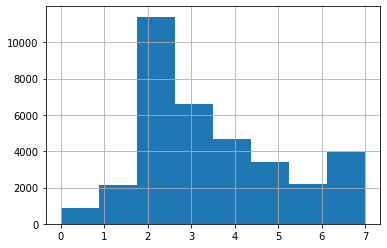

time: 208 ms


In [ ]:
histogram_age = df['age_cls'].hist(bins=df['age_cls'].nunique())

In [ ]:
#先用少量資料比較不同模型:
#每個類別各取部分資料,用train_test_split來切train and test
df_0 = df[df['age_cls'] == 0]
df_1 = df[df['age_cls'] == 1]
df_2 = df[df['age_cls'] == 2]
df_3 = df[df['age_cls'] == 3]
df_4 = df[df['age_cls'] == 4]
df_5 = df[df['age_cls'] == 5]
df_6 = df[df['age_cls'] == 6]
df_7 = df[df['age_cls'] == 7]
# train and val data
if FULL_DATA == 1:
    train_df = pd.concat([df_0[:-100], df_1[:-100], df_2[:-100], df_3[:-100], 
        df_4[:-100], df_5[:-100], df_6[:-100], df_7[:-100] ])    
else:    
    #先用少量資料比較不同模型
    train_df = pd.concat([df_0[:per_cls], df_1[:per_cls], df_2[:per_cls], df_3[:per_cls], 
        df_4[:per_cls], df_5[:per_cls], df_6[:per_cls], df_7[:per_cls] ])
# predict data: 每個類別保留最後100筆資料作為predict用
predict_df = pd.concat([df_0[-100:], df_1[-100:], df_2[-100:], df_3[-100:], 
        df_4[-100:], df_5[-100:], df_6[-100:], df_7[-100:] ])
x_pre, y_pre = np.array(predict_df['full_path']), np.array(predict_df['age_cls'])
print("train:", len(train_df), "predict:", len(predict_df))

train: 4800 predict: 800
time: 65.1 ms


In [ ]:
# 處理答案 把它轉成one-hot (後面再做)
# y_train_category = to_categorical(df['age_cls'], num_classes=8)

# 切分訓練data
x_train, x_test, y_train, y_test = train_test_split(np.array(train_df['full_path']), np.array(train_df['age_cls']), test_size=0.2, random_state=0)

print(x_train[0], x_test[0], y_train[0], y_test[0])
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

imdb_crop/14/nm0001014_rm4047346176_1970-3-27_1975.jpg wiki_crop/02/25072702_1983-02-15_2014.jpg 0 3
(3840,) (960,) (3840,) (960,)
time: 8.17 ms


In [ ]:
detector = MTCNN()
#feature_extractor = load_model(os.path.join(model_folder_path, 'facenet_keras.h5'))

time: 296 ms


In [ ]:
# VGGFace: https://github.com/rcmalli/keras-vggface
!pip install keras_vggface
!pip install keras_applications

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
feature_extractor = VGGFace(model='resnet50', include_top=False, 
            input_shape=(224, 224, 3), pooling='avg')

time: 7.15 s


In [ ]:
feature_extractor.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_8[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [ ]:
# 固定pre-train model的參數
for lyr in feature_extractor.layers:
    lyr.trainable = False

# BN
x = BatchNormalization()(feature_extractor.output)    
    
# MLP    
# x = Flatten()(x)

#x = Dense(units=2048, activation='relu')(x)
#x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(units=8, activation='softmax')(x)
age_model = Model(inputs=feature_extractor.input, outputs=x)   
age_model.summary() 

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_8[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________

In [ ]:
age_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

age_model.load_weights(os.path.join(model_folder_path,'1_vggface_weight_mlp128-8_cls600.h5'))

time: 14.6 ms


In [ ]:
# 資料預處理 for facenet?
# Standardization
def preprocess(imgs): 
    for i in range(imgs.shape[0]):
        # standardization
        img = imgs[i]
        mean, std = img.mean(), img.std()
        img = (img - mean) / std
        imgs[i] = img
    return imgs
# Normalization
def normalize(img):
    return img / 255.

# -1 <= x <= 1
def preprocess_1(imgs):
    x = np.array(imgs, dtype = float)
    x /= 127.5
    x -= 1.
    return x    

time: 6.42 ms


In [ ]:
# detect face
def detect_faces(img):
    face_imgs = []
    results = detector.detect_faces(img)
    # extract the bounding box from the first face
    # print('# of faces: ', len(results))
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[y1:y2, x1:x2] # crop face
        face_imgs.append(patch)
    return face_imgs

time: 3.62 ms


In [ ]:
def data_generator(data_paths, y, batch_size=BATCH_SIZE):
    '''data generator for fit_generator'''
    n = len(data_paths)
    i = 0
    data_paths = data_paths
    
    while True:
        x_ori, x_norm, y_ori = [], [], []
        i_batch = i
        for b in range(batch_size):
            path = data_paths[i]
            #print("idx:", i, "cls:", y[i], path)
        
            # 讀取圖片,切下臉的部分,並使用借來的模型的預處理方式來作預處理           
            img = cv2.imread(os.path.join(img_folder_path,path))[:,:,::-1]
            
            # plt.imshow(img)
            # plt.show()
            faces = detect_faces(img)
            if len(faces) == 0 or faces[0].shape[0] == 0:
                print('No face')
                i = (i+1) % n
                continue   
            img_crop = cv2.resize(faces[0], (IMG_SIZE, IMG_SIZE))
            # plt.imshow(faces[0])
            # plt.show()

            # 使用借來的模型的預處理方式來作預處理
            img_pre = preprocess_input(np.array(img_crop,dtype=float))

            # 把原圖留下來
            x_ori.append(img)
            x_norm.append(img_pre)
            y_ori.append(y[i])
            
            i = (i+1) % n

        # print("len(image_data)",len(x_ori))
        # plt.figure(figsize=(10, 40))
        # for j,m in enumerate(x_ori):
        #     plt.subplot(1, BATCH_SIZE, (j%BATCH_SIZE)+1)
        #     plt.title("idx:{} y:{}".format(i_batch+j, y[i_batch+j]))
        #     plt.axis("off")
        #     plt.imshow(m)
        # plt.show()    
        y_category = to_categorical(y_ori, num_classes=8)    
        yield np.array(x_norm), np.array(y_category)

time: 30 ms


In [ ]:
# 用generator產生資料
generator_train = data_generator(x_train, y_train, batch_size=BATCH_SIZE)
generator_test = data_generator(x_test, y_test, batch_size=BATCH_SIZE)
type(generator_train)

generator

time: 11.4 ms


In [ ]:
if FULL_DATA == 1:
    weights = {0:12., 1:5., 2:1., 3:2., 4:3., 5:4., 6:6., 7:3.}
else:    
    # for temp
    weights = {0:1., 1:1., 2:1., 3:1., 4:1., 5:1., 6:1., 7:1.}

time: 3.51 ms


In [ ]:
# fit_generator
checkpoint = ModelCheckpoint(os.path.join(model_folder_path,"1_vggface_mlp128-8_epoch.h5"), 
                save_best_only=False)   #Defaults: save_freq='epoch', save_weights_only=False
earlystop = EarlyStopping(patience=5, restore_best_weights=True)
logs = age_model.fit(generator_train,
                epochs=EPOCHS,
                steps_per_epoch=len(x_train)//BATCH_SIZE,
                validation_data=generator_test,
                validation_steps=len(x_test)//BATCH_SIZE,
                class_weight=weights,
                #validation_split=0.1,
                callbacks=[checkpoint, earlystop] 
                )

960/960 [==============================] - ETA: 0s - loss: 1.8679 - accuracy: 0.3944No face
No face
No face
No face
960/960 [==============================] - 3716s 4s/step - loss: 1.8679 - accuracy: 0.3944 - val_loss: 1.4497 - val_accuracy: 0.4780
time: 1h 2min 1s


In [ ]:
age_model.save_weights(os.path.join(model_folder_path,'1_vggface_weight_mlp128-8_cls600.h5'))

time: 1.54 s


In [ ]:
cur_train_idx = 0
cur_test_idx = 0
def get_data(x, y, batch=20, IMG_SIZE=160, test=1):
    # 要注意 numpy 中的 randint 的上限是不包含的 和一般的randint不同
    # numpy array 的索引可以是個 list, 即可同時取出不只一個元素
    global cur_train_idx, cur_test_idx
    print("cur train/test idx:", cur_train_idx, cur_test_idx)    
    if test == 0:
        #idx = np.random.randint(0, len(x), batch)
        idx = list(range(cur_train_idx, cur_train_idx+batch, 1))
        cur_train_idx = (cur_train_idx + batch) % len(x)
    else:
        idx = np.random.randint(0, len(x), batch)
        #idx = list(range(cur_test_idx, cur_test_idx+batch, 1))
        cur_test_idx += batch

    #print("idx:", idx, x[idx], y[idx])
    x_idx = x[idx]
    y_idx = y[idx]
    x_ori, x_norm, y_ori = [], [], y_idx
    for i,p in enumerate(x_idx):
        print(p)
        # 讀取圖片,切下臉的部分,並使用借來的模型的預處理方式來作預處理
        img = np.array(cv2.imread(os.path.join(img_folder_path,p))[:,:,::-1])
        # plt.imshow(img)
        # plt.show()
        faces = detect_faces(img)
        if len(faces) == 0 or faces[0].shape[0] == 0:
            print('No face')
            continue   
        img = cv2.resize(faces[0], (IMG_SIZE, IMG_SIZE))
        # plt.imshow(faces[0])
        # plt.show()

        # 使用借來的模型的預處理方式來作預處理
        img_pre = preprocess_input(np.array(img,dtype=float))
        #img_pre = preprocess_1(img)
        #img_pre = normalize(img)
        
        # 把原圖留下來
        x_ori.append(img)
        x_norm.append(img_pre)
    return np.array(x_ori), np.array(x_norm), np.array(y_ori)

# 取出要用來預測的資料
x_ori_batch, x_batch, y_batch = get_data(x_pre, y_pre, batch=20, IMG_SIZE=224) 
print(y_batch)   

cur train/test idx: 0 0
wiki_crop/46/39990446_1913-04-27_1940.jpg
imdb_crop/41/nm0286941_rm3966027776_1960-4-14_1970.jpg
wiki_crop/04/469704_1991-02-17_2010.jpg
wiki_crop/80/999980_1954-06-11_2008.jpg
wiki_crop/93/4893_1952-03-22_2014.jpg
wiki_crop/20/3590120_1990-09-21_2009.jpg
wiki_crop/71/2997471_1980-07-05_2012.jpg
wiki_crop/59/37920859_1955-06-16_2008.jpg
imdb_crop/08/nm5583008_rm2864957952_2004-12-13_2014.jpg
wiki_crop/25/28924225_1998-08-25_2013.jpg
wiki_crop/10/39992510_1987-04-13_2007.jpg
imdb_crop/78/nm0498278_rm2699400960_1922-12-28_2008.jpg
wiki_crop/58/199558_1951-04-01_2004.jpg
wiki_crop/66/37963966_1961-03-29_2012.jpg
imdb_crop/45/nm4682545_rm1570754560_2007-6-6_2009.jpg
wiki_crop/01/39990201_1975-08-02_2014.jpg
imdb_crop/13/nm0889513_rm3106703360_1928-5-30_2008.jpg
wiki_crop/02/29971102_1961-04-13_2010.jpg
wiki_crop/90/4991590_1976-03-25_2012.jpg
imdb_crop/41/nm0286941_rm4083468288_1960-4-14_1970.jpg
[2 0 1 5 6 1 3 5 0 1 1 7 5 5 0 3 7 4 3 0]
time: 15.4 s


In [ ]:
# predict
pre = age_model.predict(x_batch).argmax(axis=-1)
pre

array([2, 0, 1, 4, 5, 0, 3, 6, 1, 1, 1, 7, 6, 5, 4, 3, 6, 2, 4, 1])

time: 1.29 s


In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_batch, pre),
            index=["{}(真實)".format(i) for i in range(8)],
            columns=["{}(預測)".format(i) for i in range(8)] 
            )

,0(預測),1(預測),2(預測),3(預測),4(預測),5(預測),6(預測),7(預測)
0(真實),1,2,0,0,1,0,0,0
1(真實),1,3,0,0,0,0,0,0
2(真實),0,0,1,0,0,0,0,0
3(真實),0,0,0,2,1,0,0,0
4(真實),0,0,1,0,0,0,0,0
5(真實),0,0,0,0,1,1,2,0
6(真實),0,0,0,0,0,1,0,0
7(真實),0,0,0,0,0,0,1,1


time: 24.6 ms


In [ ]:
def euclidean_distance(x, y):
    sum_square = np.sum(np.square(x - y), keepdims=True)
    return np.sqrt(sum_square)

In [ ]:
def predict_age(img):
    img_size = 100
    img = normalize(img)
    img = cv2.resize(img, (img_size, img_size))
    model_input = np.zeros((1, img_size, img_size, 3))
    model_input[0] = img
    ages = age_model.predict(model_input)
    print('age: ', ages.argmax(axis=-1))
    return 

# def predict_gender(img):
#     img_size = 100
#     img = normalize(img)
#     img = cv2.resize(img, (img_size, img_size))
#     model_input = np.zeros((1, img_size, img_size, 3))
#     model_input[0] = img
#     genders = model_gender.predict(model_input)
#     gender = genders[0]
#     if gender > 0.5:
#         print('Male')
#     else:
#         print('Female')
#     return    

In [ ]:
folder_path = '/content/drive/My Drive/week10/face_detection'
def face_id(filename, IMG_SIZE=160):
    raw_img = cv2.imread(os.path.join(folder_path, filename))[:,:,::-1]
    faces = detect_faces(raw_img)
    if len(faces) == 0:
        print('No face')
        return
    else:
        # get face embeddings
        face = faces[0]
        # More predictions
        predict_age(face)
        # predict_emotion(face)
        # predict_gender(face)
        # # ID
        # face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        # model_input = np.zeros((1, IMG_SIZE, IMG_SIZE, 3))
        # model_input[0] = face
        # model_input = preprocess(model_input)
        # query_embeddings = feature_extractor.predict(model_input)
        # query_embedding = query_embeddings[0]
        
        # # compute distance
        # distances = np.zeros((len(embeddings)))
        # for i, embed in enumerate(embeddings):
        #     distance = euclidean_distance(embed, query_embedding)
        #     distances[i] = distance

        # # find min distance    
        # idx_min = np.argmin(distances)
        # distance, name = distances[idx_min], names[idx_min]
        # print('name: ', name, ' distance: ',distance)

In [ ]:
path = 'face3.jpg'
face_id(path)
plt.imshow(cv2.imread(os.path.join(folder_path, path))[:,:,::-1])